In [1]:
import numpy as np # linear algebra
import pandas as pd
import torch
import os
import ml_eke
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
def get_samples(start, end, columns, model_data, predictands=['EKE_sfc']):

    samples = []
    targets = []
    for sample in tqdm(range(start, end), desc="Extracting samples"):
        X, Y, mask = model_data.extract_sample_from_time(predictors=columns, predictands=predictands, sample_idx=sample)
        samples.append(pd.DataFrame(X.data, columns=columns))
        targets.append(pd.DataFrame(Y.data, columns=["EKE"]))

    data = pd.concat(samples).reset_index()
    data.drop("index", inplace=True, axis=1)
    targets = pd.concat(targets).reset_index()
    targets.drop("index", inplace=True, axis=1)
    data["EKE"] = targets["EKE"]
    
    return data


In [21]:
columns_6_features = ['MKE_sfc',
                      'slope_z',
                      'Rd_dx_z',
                      'relative_vorticity_sfc',
                      'divergence_sfc',
                      'deformation_sfc'
                      ]

columns_4_features = columns_6_features[0:4]

columns_5_features = columns_4_features + ['grad_SSH_sfc']

columns = columns_4_features

model_path = './ml_eke/nn/pytorch/trained_models/ResNetSmall_4_custom.pkl'
model_name = os.path.basename(model_path).split('.')[0]

model_mse = torch.load(model_path, map_location=torch.device('cpu'))

datapaths_2_3 = ('/lus/scratch/ashao/data/2_3/', '/lus/scratch/ashao/data/2_3_SSH/')
first_suffixes_2_3 = ('_01_001.nc', '_16_001.nc')
datapaths_1_4 = ('/lus/scratch/ashao/data/1_4/', '/lus/scratch/ashao/data/1_4_SSH/')
first_suffixes_1_4 = ('_1915_001.nc', '_18_001.nc')

datapaths = datapaths_2_3
first_suffixes = first_suffixes_2_3

last_dir = os.path.normpath(datapaths[0]).split(os.sep)[-1]

model_data = ml_eke.pop_data(datapaths[0], datapaths[0], skip_vars = ['x','y','depth','depth_stdev'], extra_pref=None, first_suffix=first_suffixes[0])
model_data.extend_inventory(datapaths[1],first_suffix=first_suffixes[1])

X_train = np.load('./ml_eke/nn/data/X_train_cf_all_4_feat.npy')
y_train = np.load('./ml_eke/nn/data/y_train_cf_all_4_feat.npy')

num_samples = 365 # one year should be enough.
dataset = get_samples(0, num_samples, columns, model_data, predictands=['MEKE_z'])

Extracting samples: 100%|██████████| 365/365 [00:08<00:00, 45.15it/s]


In [26]:
feats = dataset.values.copy()[:, 0:len(columns)]

feats[:,[0,1,3]] = np.log(np.abs(feats[:,[0,1,3]]))*np.sign(feats[:,[0,1,3]])+36.0*np.sign(feats[:,[0,1,3]])

feat_avg = np.mean(feats, axis=0, dtype=np.float64)
feat_sd  = np.std(feats, axis=0, dtype=np.float64)

feats = (feats-feat_avg)/feat_sd

In [26]:
targ_avg = np.mean(y_train, dtype=np.float64)
targ_sd  = np.std(y_train, dtype=np.float64)

In [95]:
chunk_size = 10000
preds = np.zeros((feats.shape[0],1))

for chunk in tqdm(range(feats.shape[0]//chunk_size)):
    loc_feats = torch.tensor(feats[chunk*chunk_size:(chunk+1)*chunk_size,:], dtype=torch.float32)
    preds[chunk*chunk_size:(chunk+1)*chunk_size] = model_mse(loc_feats).detach().numpy()
    if chunk == 0:
        print(preds[:10, :])
    
if feats.shape[0]%chunk_size != 0:
    chunk = feats.shape[0]//chunk_size
    loc_feats = torch.tensor(feats[chunk*chunk_size:,:], dtype=torch.float32)
    preds[chunk*chunk_size:] = model_mse(loc_feats).detach().numpy()
    

  0%|          | 1/5170 [00:00<46:51,  1.84it/s]

[[-5.57154036]
 [-5.08483839]
 [-4.95142841]
 [-4.87737179]
 [-4.61313963]
 [-4.6920557 ]
 [-4.65319967]
 [-4.9012332 ]
 [-5.34919882]
 [-5.74147463]]


100%|██████████| 5170/5170 [25:12<00:00,  3.42it/s]


In [115]:
print(np.sum(preds==0.0))
# Can't use all preds, because of overflows. Use 10M. OK, next time do this before computing the preds.
ids = np.random.choice(preds.shape[0], size=10000000, replace=False);
pred_avg = np.mean(preds[ids], dtype=np.float64)
pred_sd  = np.std(preds[ids], dtype=np.float64)


0


In [116]:
print(repr(pred_avg), targ_avg, repr(feat_avg))
print(pred_sd,  targ_sd,  repr(feat_sd))

-5.723821309455049 -5.17934491016621 array([30.92578546, 29.65081059,  0.70335406,  0.15926934])
1.0059181107879616 0.9947459262875877 array([ 1.70855685,  2.19210219,  0.79489046, 21.02535184])


In [106]:
# torchscript
model_mse.eval()

class InferenceCell(torch.nn.Module):
    
    def __init__(self):
        super(InferenceCell, self).__init__()
        self.model = model_mse

        self.feat_avg = torch.tensor(feat_avg, dtype=torch.float32)
        self.feat_sd = torch.tensor(feat_sd, dtype=torch.float32)
        self.targ_avg = torch.tensor(targ_avg, dtype=torch.float32)
        self.targ_sd = torch.tensor(targ_sd, dtype=torch.float32)
        self.pred_avg = torch.tensor(pred_avg, dtype=torch.float32)
        self.pred_sd = torch.tensor(pred_sd, dtype=torch.float32)
        
    def forward(self, x):
        x[:,[0,1,3]] = torch.log(torch.abs(x[:,[0,1,3]]))*torch.sign(x[:,[0,1,3]])+36.0*torch.sign(x[:,[0,1,3]])
        x1 = (x - self.feat_avg) / self.feat_sd
        x2 = self.model(x1)
        x3 = x2 - self.pred_avg
        x4 = x3 / self.pred_sd
        x5 = x4 * self.targ_sd
        x6 = x5 + self.targ_avg
        
        return x6

inference_cell = InferenceCell()
x = torch.tensor(dataset.values.copy()[0:10,0:len(columns)])
#print(f'{x} out')
traced_cell = torch.jit.trace(inference_cell, (x))
#print(traced_cell.code)
x = torch.tensor(dataset.values.copy()[0:10,0:len(columns)])
#print(f'{x} out')
print("return: ", traced_cell(x).detach().numpy())


return:  [[-5.077671 ]
 [-4.563232 ]
 [-4.4222174]
 [-4.343941 ]
 [-4.0646496]
 [-4.1480637]
 [-4.106992 ]
 [-4.3691616]
 [-4.842657 ]
 [-5.2572885]]


In [107]:
print(preds[0:10])
print(feats[:10, :4])
print(model_mse(torch.tensor(feats[:10, :4], dtype=torch.float32)).detach().numpy())

[[-5.57154036]
 [-5.08483839]
 [-4.95142841]
 [-4.87737179]
 [-4.61313963]
 [-4.6920557 ]
 [-4.65319967]
 [-4.9012332 ]
 [-5.34919882]
 [-5.74147463]]
[[ 0.21679954 -0.33105676 -0.75329554  1.07551771]
 [ 0.35406937 -0.39733056 -0.75055879  0.99420877]
 [ 0.41475531 -0.47276042 -0.75298457  0.97446748]
 [ 0.45192979 -0.63012153 -0.75346326  0.97307824]
 [ 0.47283457 -1.29493727 -0.75096281  0.96675838]
 [ 0.48238384 -1.51427562 -0.74641188  0.96039815]
 [ 0.47231882 -1.18734416 -0.74088107  0.96461565]
 [ 0.43794526 -0.52951793 -0.73613451  0.98438444]
 [ 0.36488346  0.01241182 -0.73698827  1.0215631 ]
 [ 0.22710346  0.14936821 -0.73914171  1.05081503]]
[[-5.5715404]
 [-5.0848384]
 [-4.9514284]
 [-4.877372 ]
 [-4.6131396]
 [-4.6920557]
 [-4.6531997]
 [-4.901233 ]
 [-5.349199 ]
 [-5.7414746]]


In [108]:
save = True
load = False

last_dir = os.path.normpath(datapaths[0]).split(os.sep)[-1]
if save:
    traced_cell.save(f'./ml_eke/nn/pytorch/trained_models/{model_name}_for_{last_dir}.pt')
    
if load:
    traced_cell = torch.jit.load(f'./ml_eke/nn/pytorch/trained_models/{model_name}_for_{last_dir}.pt')
    


In [109]:
from time import time

XX = torch.tensor(dataset.values.copy()[0:100000, 0:len(columns)])

t1 = time()
y = traced_cell(XX)
t2 = time()

y = y.detach().numpy()
print(f'Elapsed time {t2-t1}')


Elapsed time 2.9712846279144287


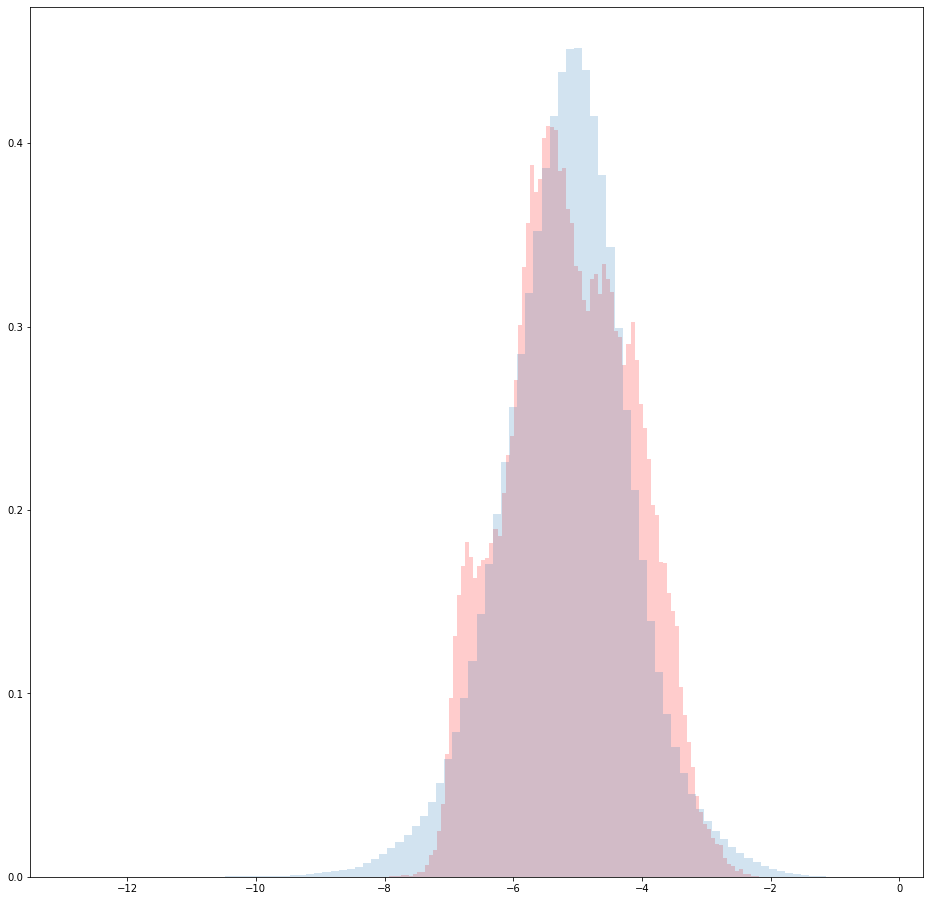

In [112]:
plt.figure(figsize=(16,16))
plt.hist(y, bins=100, density=True, alpha=0.2, color='red')
plt.hist(y_train, bins=100, density=True, alpha=0.2)
#plt.hist(preds, bins=100, density=True, alpha=0.2)
plt.draw()

In [101]:
print(np.mean((preds[0:1000001]-pred_avg)/pred_sd*targ_sd+targ_avg, dtype=np.float64), np.mean(y_train, dtype=np.float64))
print(np.std((preds[0:1000001]-pred_avg)/pred_sd*targ_sd+targ_avg, dtype=np.float64), np.std(y_train, dtype=np.float64))

-5.100686843298917 -5.17934491016621
0.6228471205961198 0.9947459262875877


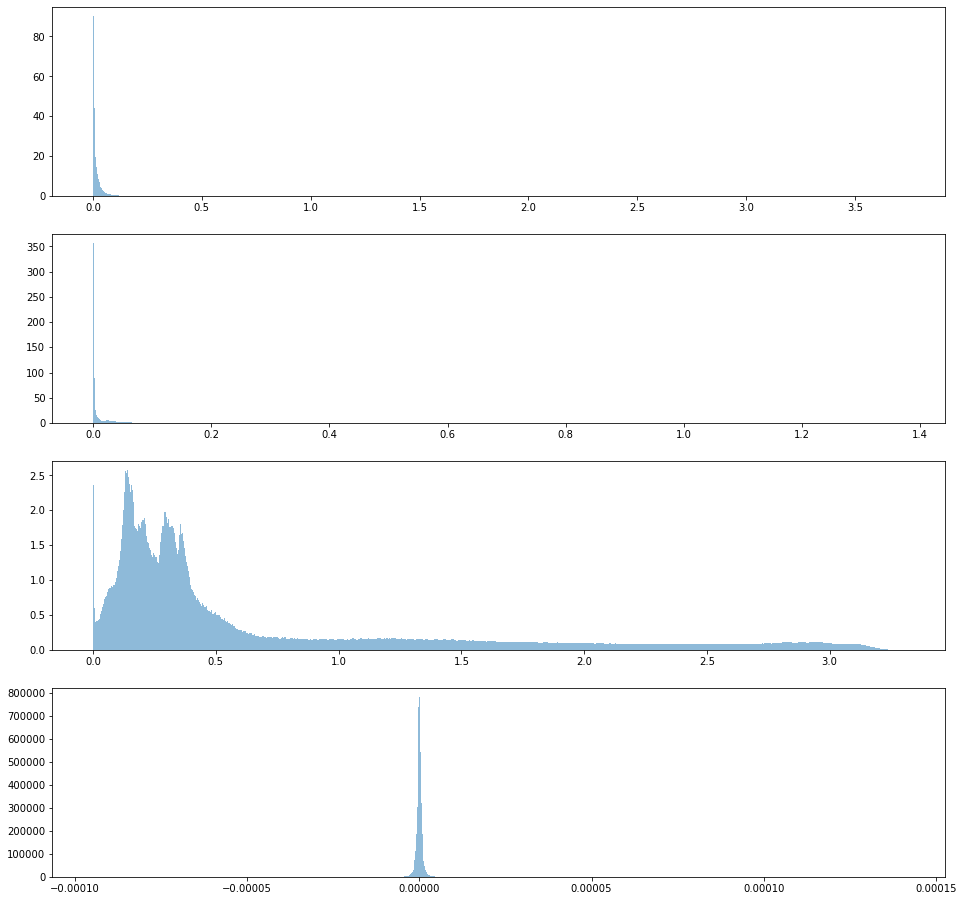

In [46]:
plt.figure(figsize=(16,16))


for i in range(feats.shape[1]):
    plt.subplot(feats.shape[1], 1, i+1)
    plt.hist(dataset.values[:,i], bins=1000, alpha=0.5, density=True)
    #plt.hist(X_train[:,i], bins=1000, alpha=0.5, density=True)
    
plt.draw()